Impact of factors on retention

Import libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import geopandas as gpd

Read turnover data from csv into a dataframe

In [49]:
month = "february"
year = "2023"
url = f'../02_data/turnover-processed-{month}-{year}.csv'
df = pd.read_csv(url, parse_dates=['Date'])
df['Date'] = pd.to_datetime(df['Date'])
#df = df.sort_values(by='Date')
#df = df.drop(['Joiner_FTE','SIP_HC','Benchmark group','ICS code','ICS name'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193670 entries, 0 to 193669
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              193670 non-null  datetime64[ns]
 1   Org code          193670 non-null  object        
 2   Org name          193670 non-null  object        
 3   NHSE region code  193670 non-null  object        
 4   NHSE region name  193670 non-null  object        
 5   Cluster group     193670 non-null  object        
 6   Benchmark group   193670 non-null  object        
 7   Staff group       193670 non-null  object        
 8   HC_Denoms         192694 non-null  float64       
 9   HC_Joiners        124069 non-null  float64       
 10  HC_Leavers        125487 non-null  float64       
 11  FTE_Denoms        192694 non-null  float64       
 12  FTE_Joiners       124069 non-null  float64       
 13  FTE_Leavers       125487 non-null  float64       
dtypes: d

Drop joiners data to create leavers dataframe. Drop CCGs and ICBs (optionally) drop some staff groups not of interest.

In [50]:

#staff_groups_todrop = ['Other staff or those with unknown classification','Managers','Senior managers','Central functions','Hotel, property & estates']
#df_leaver = df_leaver[~df_leaver['Staff group'].isin(staff_groups_todrop)]

trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_leaver = df[~df['Cluster group'].isin(trust_types_todrop)]

#df_leaver_acute = df_leaver[df_leaver['Cluster group'] == 'Acute']

df_leaver.head()


,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,HC_Denoms,HC_Joiners,HC_Leavers,FTE_Denoms,FTE_Joiners,FTE_Leavers
1271,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,All staff groups,19818.0,239.0,254.0,17710.16849,214.415,225.38810
1272,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,Central functions,1493.0,28.0,36.0,1383.70341,26.800,32.81946
1273,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,HCHS doctors (exc. junior Drs),1254.0,14.0,17.0,1145.69755,11.775,14.34600
1274,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,"Hotel, property & estates",263.0,2.0,1.0,220.82146,2.000,1.00000
1275,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,Managers,198.0,NaN,2.0,189.61478,NaN,2.00000


The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [61]:
url_r1 = '../02_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.head()

,Date,Region,NHSE region name,%,thousands
0,1992-04-01,East Midlands,Midlands,0.087,177
1,1992-04-01,East of England,East of England,0.079,210
2,1992-04-01,London,London,0.123,424
3,1992-04-01,North East,North East,0.122,146
4,1992-04-01,North West,North West,0.101,331


In [63]:
#df_r1['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

# drop type thousands, only use %s
#df_r1 = df_r1[df_r1['Type'] != 'thousands']

df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment'},inplace=True)
df_r1 = df_r1.sort_values('Date')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3339 entries, 0 to 3338
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                3339 non-null   datetime64[ns]
 1   NHSE region name    3339 non-null   object        
 2   local_unemployment  3339 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.3+ KB


Add data about local unemployment at the regional level to the main dataframe

In [64]:
df_leaver_r1 = pd.merge(df_leaver, df_r1, on=['Date', 'NHSE region name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171952 entries, 0 to 171951
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                171952 non-null  datetime64[ns]
 1   Org code            171952 non-null  object        
 2   Org name            171952 non-null  object        
 3   NHSE region code    171952 non-null  object        
 4   NHSE region name    171952 non-null  object        
 5   Cluster group       171952 non-null  object        
 6   Benchmark group     171952 non-null  object        
 7   Staff group         171952 non-null  object        
 8   HC_Denoms           171657 non-null  float64       
 9   HC_Joiners          128200 non-null  float64       
 10  HC_Leavers          128327 non-null  float64       
 11  FTE_Denoms          171657 non-null  float64       
 12  FTE_Joiners         128200 non-null  float64       
 13  FTE_Leavers         128327 no

Load data about sickness absence to use as second regressor

In [65]:
url_r2 = 'sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop('Benchmark group',axis=1)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267954 entries, 0 to 267953
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                267954 non-null  datetime64[ns]
 1   Org code            267954 non-null  object        
 2   Org name            267954 non-null  object        
 3   NHSE region code    267954 non-null  object        
 4   NHSE region name    267954 non-null  object        
 5   Cluster group       267954 non-null  object        
 6   Staff group         267954 non-null  object        
 7   FTE days lost       233554 non-null  float64       
 8   FTE days available  233554 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 18.4+ MB


In [109]:
df_r2.head()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Staff group,FTE days lost,FTE days available
0,2018-03-01,RT3,Royal Brompton and Harefield NHS Foundation Trust,Y56,London,Acute,"Hotel, property & estates",202.97333,4692.62646
1,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Managers,150.75336,7272.63377
2,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Nurses & health visitors,35.64000,2327.04646
3,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,"Scientific, therapeutic & technical staff",10.39998,504.83363
4,2018-03-01,0DE,NHS Arden and Greater East Midlands Commission...,QZZ,Special Health Authorities and other statutory...,Commissioning Support Unit,Senior managers,0.00000,1106.63354


Add sickness absence data to the main dataframe

In [114]:
merge_cols = ['Date', 'Org code','Org name','NHSE region code','NHSE region name','Cluster group','Staff group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180821 entries, 0 to 180820
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                180821 non-null  datetime64[ns]
 1   Org code            180821 non-null  object        
 2   Org name            180821 non-null  object        
 3   NHSE region code    180821 non-null  object        
 4   NHSE region name    180821 non-null  object        
 5   Cluster group       180821 non-null  object        
 6   Benchmark group     180821 non-null  object        
 7   Staff group         180821 non-null  object        
 8   HC_Denoms           180517 non-null  float64       
 9   HC_Joiners          135157 non-null  float64       
 10  HC_Leavers          135373 non-null  float64       
 11  FTE_Denoms          180517 non-null  float64       
 12  FTE_Joiners         135157 non-null  float64       
 13  FTE_Leavers         135373 no

In [115]:
df_leaver_r2['Date'].max()
#date_max = df['Date'].max()

Timestamp('2023-02-01 00:00:00')

In [117]:
df_leaver_r2.tail()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,HC_Denoms,HC_Joiners,HC_Leavers,FTE_Denoms,FTE_Joiners,FTE_Leavers,local_unemployment,FTE days lost,FTE days available
180816,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Senior managers,56.0,NaN,NaN,55.60000,NaN,NaN,0.037,NaN,NaN
180817,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Support to ST&T staff,437.0,NaN,NaN,402.21200,NaN,NaN,0.051,NaN,NaN
180818,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,Support to ST&T staff,437.0,NaN,NaN,402.21200,NaN,NaN,0.037,NaN,NaN
180819,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",999.0,NaN,NaN,871.02637,NaN,NaN,0.051,NaN,NaN
180820,2023-02-01,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",999.0,NaN,NaN,871.02637,NaN,NaN,0.037,NaN,NaN


Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [100]:
sorted(df_leaver_r2['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [101]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r2[df_leaver_r2['Staff group'] == staff_group].copy()

df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
df_sg['leaver_rate'] = df_sg['FTE_Leavers']/df_sg['FTE_Denoms']

df_sg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15188 entries, 6 to 180812
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   15188 non-null  datetime64[ns]
 1   Org code               15188 non-null  object        
 2   Org name               15188 non-null  object        
 3   NHSE region code       15188 non-null  object        
 4   NHSE region name       15188 non-null  object        
 5   Cluster group          15188 non-null  object        
 6   Benchmark group        15188 non-null  object        
 7   Staff group            15188 non-null  object        
 8   HC_Denoms              15182 non-null  float64       
 9   HC_Joiners             14561 non-null  float64       
 10  HC_Leavers             14602 non-null  float64       
 11  FTE_Denoms             15182 non-null  float64       
 12  FTE_Joiners            14561 non-null  float64       
 13  FTE_L

In [102]:
# List of columns to replace NaN values with 0
cols = ['sickness_absence_rate', 'leaver_rate']

# Replace NaN values with 0 in the specified columns
df_sg[cols] = df_sg[cols].fillna(0)

df_sg.reset_index(drop=True)
df_sg.head()

,Date,Org code,Org name,NHSE region code,NHSE region name,Cluster group,Benchmark group,Staff group,HC_Denoms,HC_Joiners,HC_Leavers,FTE_Denoms,FTE_Joiners,FTE_Leavers,local_unemployment,FTE days lost,FTE days available,sickness_absence_rate,leaver_rate
6,2018-07-01,R0A,Manchester University NHS Foundation Trust,Y62,North West,Acute,Acute - Teaching,Nurses & health visitors,6200.0,45.0,72.0,5594.45451,39.66667,64.95199,0.043,7720.57851,174601.19070,0.044218,0.011610
24,2018-07-01,R1A,Herefordshire and Worcestershire Health and Ca...,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,1185.0,9.0,18.0,1016.13304,8.24000,14.26000,0.049,1409.23965,31672.88560,0.044494,0.014034
25,2018-07-01,R1A,Herefordshire and Worcestershire Health and Ca...,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,1185.0,9.0,18.0,1016.13304,8.24000,14.26000,0.045,1409.23965,31672.88560,0.044494,0.014034
41,2018-07-01,R1C,Solent NHS Trust,Y59,South East,Community Provider Trust,Community Provider Trust,Nurses & health visitors,911.0,7.0,11.0,766.35227,6.24000,8.53333,0.038,1203.80204,24088.32367,0.049975,0.011135
57,2018-07-01,R1D,Shropshire Community Health NHS Trust,Y60,Midlands,Community Provider Trust,Community Provider Trust,Nurses & health visitors,573.0,6.0,8.0,476.71546,5.16000,6.96000,0.049,774.95555,14814.41883,0.052311,0.014600


Explore independent and dependent variables

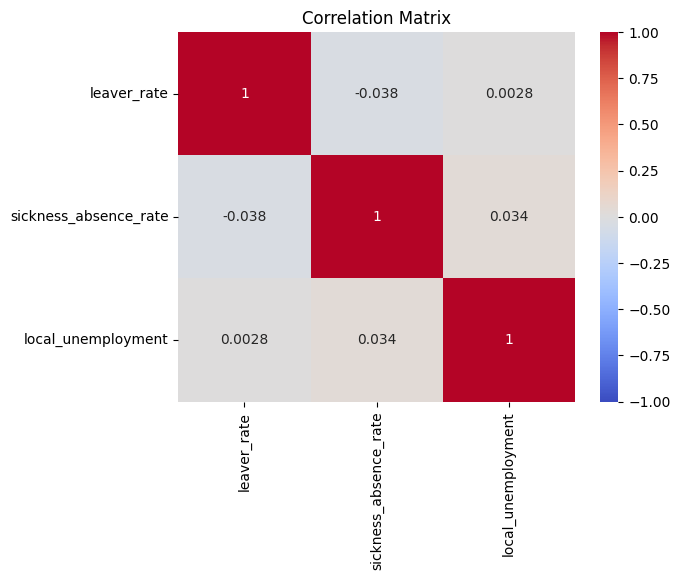

In [103]:
correlation_matrix = df_sg[['leaver_rate', 'sickness_absence_rate', 'local_unemployment']].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [82]:
#df_with_dummies = pd.get_dummies(df_leaver, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [104]:
dv = 'leaver_rate'
ivs = ['local_unemployment','sickness_absence_rate']
to_drop = ['Date','Org code','Org name','NHSE region name','NHSE region code','Cluster group','Benchmark group',
           'Staff group', 'FTE_Denoms', 'FTE_Leavers', 'FTE_Joiners','HC_Denoms','HC_Leavers','HC_Joiners','FTE days lost','FTE days available', dv]

Define the design matrix (X) and the dependent variable (y)


In [105]:
df_sg.reset_index(drop = True)
X = df_sg.drop(to_drop, axis=1)
y = df_sg[dv]

#y = y.dropna()

y.head()


6     0.011610
24    0.014034
25    0.014034
41    0.011135
57    0.014600
Name: leaver_rate, dtype: float64

In [106]:
#X = X.dropna()

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,local_unemployment,sickness_absence_rate
180775,1.0,0.039,0.0
180786,1.0,0.047,0.0
180796,1.0,0.039,0.0
180811,1.0,0.051,0.0
180812,1.0,0.037,0.0


In [107]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.37
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           1.17e-05
Time:                        16:29:03   Log-Likelihood:                 28772.
No. Observations:               15188   AIC:                        -5.754e+04
Df Residuals:                   15185   BIC:                        -5.751e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.01

In [ ]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1210      0.003     46.375      0.000       0.116       0.126
local_unemployment       -0.0019      0.000     -3.850      0.000      -0.003      -0.001
sickness_absence_rate     0.0524      0.027      1.968      0.049       0.000       0.105


This model uses region and type of provider to try and predict NHS staff leaver FTE. The R squared is 0.054, meaning the factors in the model only explain 5.4% of the variation in the data. A lower adjusted R squared than R squared would tell us that some of the model's factors are not contibuting - this is not the case here. 
All variables contribute significantly except being in the Midlands region, NE and Yorkshire, North West or South West.  
The strongest predictors are CCG